In [ ]:
from google.colab import files
import os

In [ ]:
print("Upload your kaggle.json (dans ~/.kaggle/kaggle.json)")
files.upload()
os.makedirs('/root/.kaggle', exist_ok=True)
os.replace('kaggle.json', '/root/.kaggle/kaggle.json')
!chmod 600 /root/.kaggle/kaggle.json

Upload your kaggle.json (dans ~/.kaggle/kaggle.json)


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d dhoogla/unswnb15

!unzip -q unswnb15.zip -d ./unswnb15

Dataset URL: https://www.kaggle.com/datasets/dhoogla/unswnb15
License(s): CC-BY-NC-SA-4.0
  0% 0.00/11.7M [00:00<?, ?B/s]
100% 11.7M/11.7M [00:00<00:00, 1.20GB/s]


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
import missingno as msno
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

plt.style.use('ggplot')

# Chargement du dataset (format Parquet)

In [ ]:
train_path = './unswnb15/UNSW_NB15_training-set.parquet'
test_path  = './unswnb15/UNSW_NB15_testing-set.parquet'

df_train = pd.read_parquet(train_path)
df_test  = pd.read_parquet(test_path)
df = pd.concat([df_train, df_test], ignore_index=True)
print(f"Loaded: train={df_train.shape}, test={df_test.shape}, combined={df.shape}")
df.info()

Loaded: train=(175341, 36), test=(82332, 36), combined=(257673, 36)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 36 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   dur                257673 non-null  float32 
 1   proto              257673 non-null  object  
 2   service            257673 non-null  category
 3   state              257673 non-null  object  
 4   spkts              257673 non-null  int16   
 5   dpkts              257673 non-null  int16   
 6   sbytes             257673 non-null  int32   
 7   dbytes             257673 non-null  int32   
 8   rate               257673 non-null  float32 
 9   sload              257673 non-null  float32 
 10  dload              257673 non-null  float32 
 11  sloss              257673 non-null  int16   
 12  dloss              257673 non-null  int16   
 13  sinpkt             257673 non-null  float32 
 14  dinpkt          

# Préparation des features → PNG 6×6

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler

# Sélection des features numériques + label
X = df.drop(columns=["label"])
X = X.select_dtypes(include=["number"])    # ne garder que les colonnes numériques
y = df["label"]

# Padding dynamique pour atteindre 36 colonnes
desired_features = 36
current_features = X.shape[1]
pads_needed = desired_features - current_features
for i in range(pads_needed):
    X[f"pad{i}"] = 0

# Normalisation entre 0 et 255
scaler = MinMaxScaler(feature_range=(0, 255))
X_scaled = scaler.fit_transform(X).astype(np.uint8)

# Création des répertoires images
os.makedirs("images/normal", exist_ok=True)
os.makedirs("images/attack", exist_ok=True)

# Génération des images PNG 6×6
for i in tqdm(range(len(X_scaled)), desc="Génération PNG"):
    img = Image.fromarray(X_scaled[i].reshape(6, 6), mode="L")
    cls = "normal" if y.iloc[i] == 0 else "attack"
    img.save(f"images/{cls}/{i}.png")

Génération PNG:   0%|          | 0/257673 [00:00<?, ?it/s]/tmp/ipython-input-11-2342456150.py:30: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(X_scaled[i].reshape(6, 6), mode="L")
Génération PNG: 100%|██████████| 257673/257673 [00:49<00:00, 5179.03it/s]


# Chargement des datasets TensorFlow (0–1)

In [28]:
batch_size = 64
img_size = (6, 6)
data_dir = "images"

# — Training set —
raw_train = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    label_mode="binary",
    class_names=["normal","attack"],
    batch_size=batch_size,
    image_size=img_size,
    color_mode="grayscale"
)

# — Validation set —
raw_val = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    label_mode="binary",
    class_names=["normal","attack"],
    batch_size=batch_size,
    image_size=img_size,
    color_mode="grayscale"
)

def normalize(images, labels):
    return images / 255.0, labels

train_ds = raw_train.map(normalize).cache().prefetch(tf.data.AUTOTUNE)
val_ds   = raw_val.map(normalize).cache().prefetch(tf.data.AUTOTUNE)

Found 257673 files belonging to 2 classes.
Using 206139 files for training.
Found 257673 files belonging to 2 classes.
Using 51534 files for validation.


# Définition du CNN

In [29]:
model = models.Sequential([
    layers.Input(shape=(6, 6, 1)),
    layers.Conv2D(32, (3,3), activation="relu", padding="same"),
    layers.MaxPool2D(),
    layers.Conv2D(64, (3,3), activation="relu", padding="same"),
    layers.MaxPool2D(),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 6, 6, 32)       │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,041 (90.00 KB)

 Trainable params: 23,041 (90.00 KB)

 Non-trainable params: 0 (0.00 B)

# Entraînement

In [30]:
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
3221/3221 ━━━━━━━━━━━━━━━━━━━━ 33s 10ms/step - accuracy: 0.7998 - loss: 0.3843 - val_accuracy: 0.8918 - val_loss: 0.2137
Epoch 2/30
3221/3221 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8894 - loss: 0.2190 - val_accuracy: 0.8982 - val_loss: 0.2002
Epoch 3/30
3221/3221 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8945 - loss: 0.2044 - val_accuracy: 0.9024 - val_loss: 0.1886
Epoch 4/30
3221/3221 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8995 - loss: 0.1946 - val_accuracy: 0.9042 - val_loss: 0.1796
Epoch 5/30
3221/3221 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9018 - loss: 0.1866 - val_accuracy: 0.9061 - val_loss: 0.1749
Epoch 6/30
3221/3221 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9046 - loss: 0.1806 - val_accuracy: 0.9080 - val_loss: 0.1724
Epoch 7/30
3221/3221 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9056 - loss: 0.1770 - val_accuracy: 0.9073 - val_loss: 0.1718
Epoch 8/30
3221/3221 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9067 - loss: 0.

# Visualisation des courbes

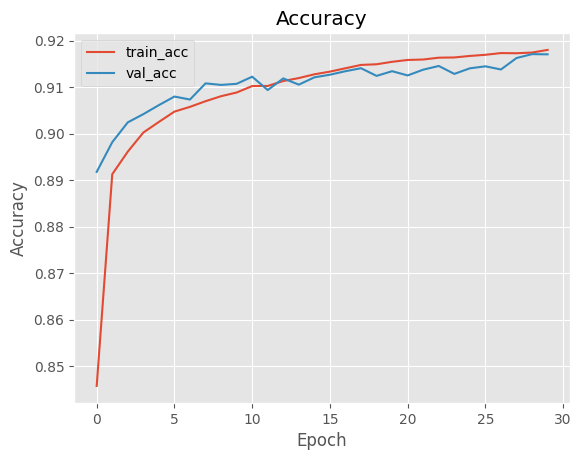

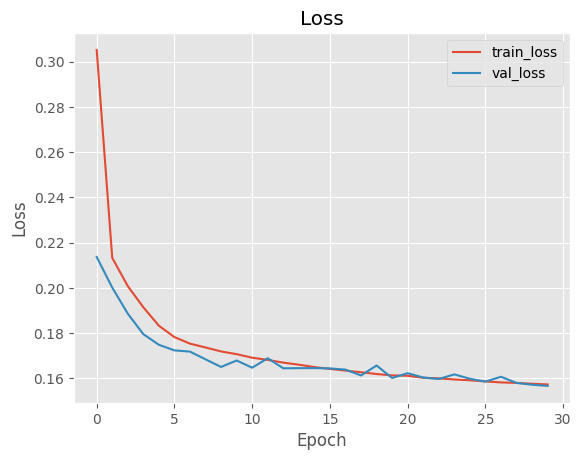

In [33]:
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.show()

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# Afficher côte‑à‑côte 1 normal + 1 attack

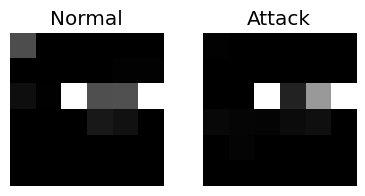

In [51]:
normal_path = f"images/normal/{random.choice(normal_files)}"
attack_path = f"images/attack/{random.choice(attack_files)}"
normal_img = Image.open(normal_path)
attack_img = Image.open(attack_path)

fig, axes = plt.subplots(1, 2, figsize=(4, 2))
axes[0].imshow(normal_img, cmap="gray", vmin=0, vmax=255)
axes[0].set_title("Normal")
axes[0].axis("off")

axes[1].imshow(attack_img, cmap="gray", vmin=0, vmax=255)
axes[1].set_title("Attack")
axes[1].axis("off")

plt.tight_layout()
plt.show()

# Prédictions avec pourcentage de confiance

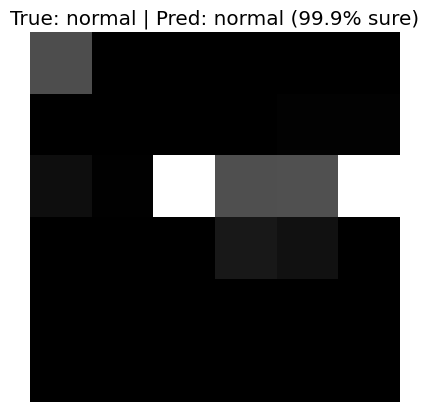

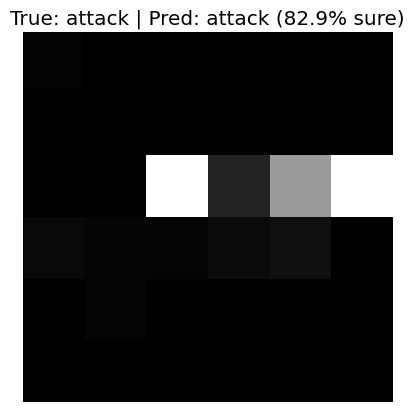

In [53]:
def predict_and_show(img_path, true_label):
    img = Image.open(img_path)
    arr = np.array(img).reshape(1, 6, 6, 1).astype("float32") / 255.0
    score = model.predict(arr, verbose=0)[0][0]
    percent = score * 100 if true_label == "attack" else (1 - score) * 100
    pred = "attack" if score > 0.5 else "normal"
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"True: {true_label} | Pred: {pred} ({percent:.1f}% sure)")
    plt.show()

# Exemple NORMAL
predict_and_show(normal_path, "normal")

# Exemple ATTACK
predict_and_show(attack_path, "attack")